# TUTORIAL 3: Neural Neighbor Style Transfer
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed Pytorch and Augmentare properly.

This tutorial uses the highly popular Neural Neighbor Style Transfer **NNST** architecture. **Augmentare** provides a generalised implementation of **NNST**.

**Paper** - [Neural Neighbor Style Transfer by Nick Kolkin & al.](https://arxiv.org/pdf/2203.13215v1.pdf)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt

# Pytorch and Torchvision Imports
import imageio.v3 as iio
from PIL import Image
import IPython.display as display
import torch
import torch.nn.functional as F

# Augmentare Imports
import augmentare
from augmentare.methods.style_transfer import *

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING

This tutorial uses the [**LOw Light paired dataset (LOL)**](https://daooshee.github.io/BMVC2018website/) dataset for illustration purposes. 

Here the content image is the low-light image and the style image is the well-lit image that we want to aim for.

In [4]:
def scl_spatial(x, h, w):
    """
    Shorter alias for default way I call F.interpolate (i.e. as bilinear
    interpolation
    """
    return F.interpolate(x, (h, w), mode='bilinear', align_corners=True)

In [5]:
def load_path_for_pytorch(im_path, target_size=1000, side_comp=max, verbose=False):
    """
    Loads image at path, selects height or width with function side_comp
    then scales the image, setting selected dimension to target_size and
    maintaining aspect ratio. Will also convert RGBA or greyscale images to
    RGB

    Returns
    -------
        x -- a HxWxC pytorch tensor of rgb values scaled between 0. and 1.
    """
    # Load Image
    x = iio.imread(im_path).astype(np.float32)

    # Converts image to rgb if greyscale
    if len(x.shape) < 3:
        x = np.stack([x, x, x], 2)

    # Removes alpha channel if present
    if x.shape[2] > 3:
        x = x[:, :, :3]

    # Rescale rgb values
    x = x / 255.

    # Convert from numpy
    x_dims = x.shape
    x = torch.from_numpy(x).contiguous().permute(2, 0, 1).contiguous()

    # Rescale to desired size
    # by default maintains aspect ratio relative to long side
    # change side_comp to be min for short side
    fac = float(target_size) / side_comp(x_dims[:2])
    h = int(x_dims[0] * fac)
    w = int(x_dims[1] * fac)
    x = scl_spatial(x.unsqueeze(0), h, w)[0]

    if verbose:
        print(f'DEBUG: image from path {im_path} loaded with size {x_dims}')
    return x

In [6]:
content_path = '/home/vuong.nguyen/vuong/augmentare/Datasets/LowHigh/low/676.png'
style_path = '/home/vuong.nguyen/vuong/augmentare/Datasets/LowHigh/high/676.png'

# Load images
content_img = load_path_for_pytorch(content_path,
                                        target_size=1024).to(device).unsqueeze(0)
style_img = load_path_for_pytorch(style_path,
                                        target_size=1024).to(device).unsqueeze(0)

#### Show the content image

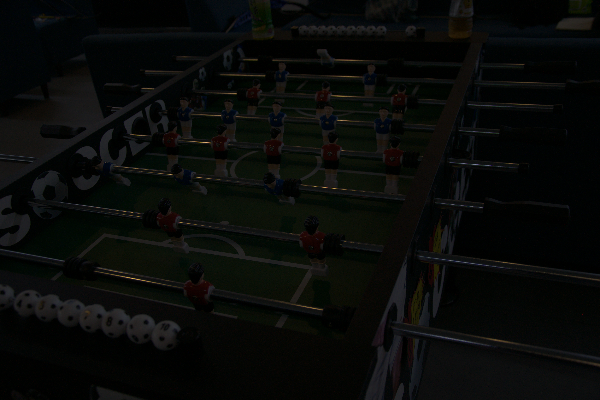

In [7]:
content_image = Image.open(content_path)
display.display(content_image)

#### Show the style image

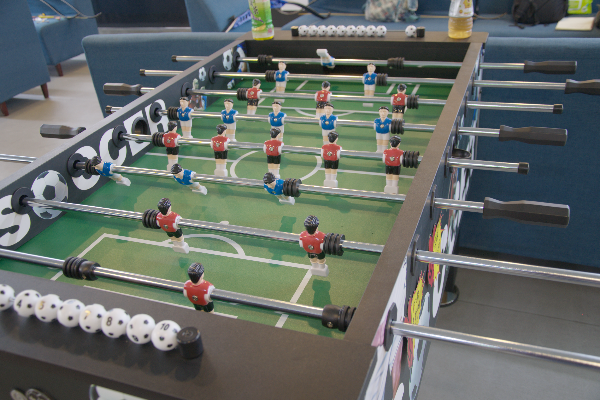

In [8]:
style_image = Image.open(style_path)
display.display(style_image)

## NETWORK ARCHITECTURE : NNST

<img src="/home/vuong.nguyen/vuong/augmentare/tutorials/imgs/nnst.png" alt="Picture" style="display: block; margin: 0 auto" />

The fast and slow variants of their method, NNST-D, and NNST-Opt, only differ in step 4; mapping from the target features to image pixels. This simplified diagram omits several details for clarity, namely: they apply steps 1-4 at multiple scales, coarse to fine; they repeat steps 1-4 several times at the finest scale; and they only apply step 5 once (optionally) at the very end.

**NNST**

Hyperparameters:

`content_im:` content image that we choose to stylizer

`style_img:` style image that we choose for style transfer

`device:` CPU or CUDA

In [9]:
model = NNST(content_img, style_img, device)

## VISUALIZE THE GENERATED DATA

**Styled images from the NNST**

A function that generates the image by NNST method.

Parameters:

`max_scales:` Number of scales to stylize (performed coarse to fine)

`alpha:` Alpha is between 0 and 1

`content_loss:` Use self-sim content loss or not

`flig_aug:` Extract features from rotations of style image too or not

`zero_init:` If true initialize w/ grey image, o.w. initialize w/ downsampled content image

`dont_colorize:` Colorize or not

Returns:

`gen_image:` Generated image

In [10]:
gen_image = model.nnst_generate(
    max_scales=5, alpha=0.75,
    content_loss=False, flip_aug=False,
    zero_init = False, dont_colorize=False
)

In [11]:
torch.cuda.empty_cache()

In [12]:
new_im_out = np.clip(gen_image[0].permute(1, 2, 0).detach().cpu().numpy(), 0., 1.)
new_im_out = (new_im_out * 255).astype(np.uint8)

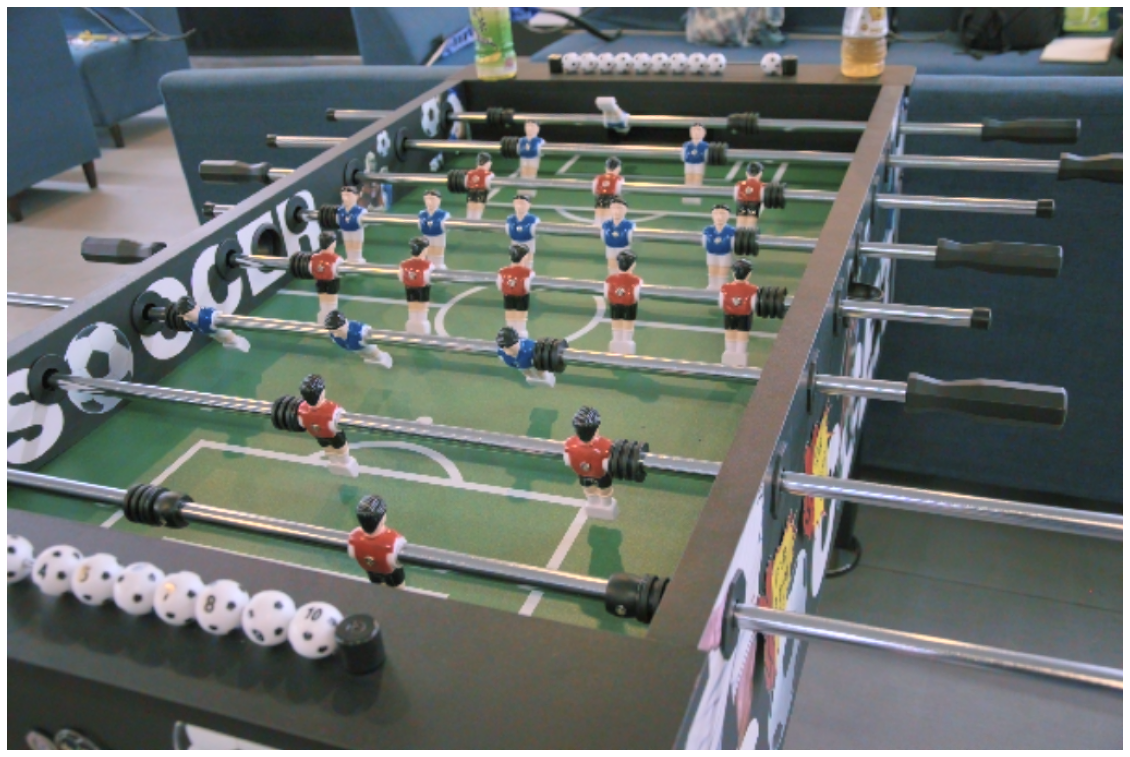

In [13]:
plt.figure(figsize=(20,25))
plt.imshow(new_im_out)
plt.axis('off')
plt.show()

In [14]:
iio.imwrite(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/nnst/gen_image_nnst_3.jpg', new_im_out)

#### Plot generated image

In [15]:
output = Image.open(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/nnst/gen_image_nnst_3.jpg')

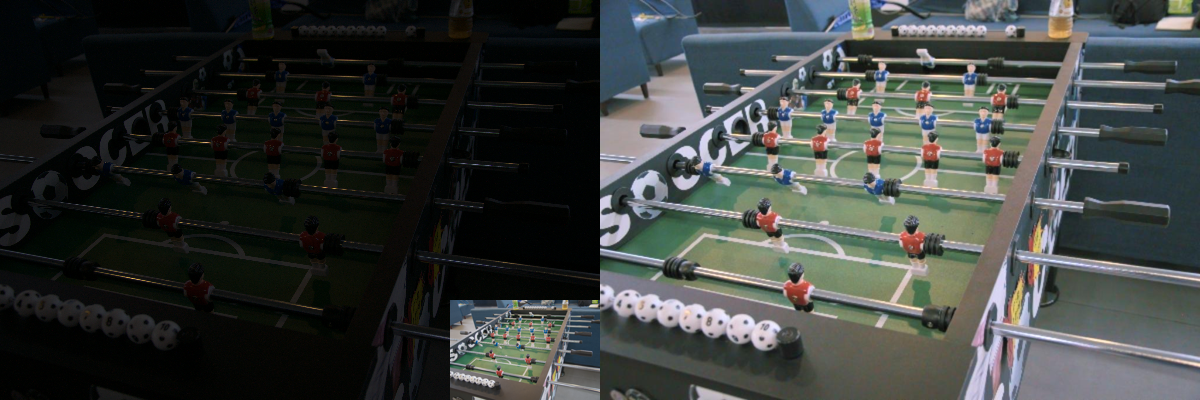

In [16]:
demo = Image.new('RGB', (content_image.width * 2, content_image.height))
output = output.resize(content_image.size)
style_image = style_image.resize((i // 4 for i in content_image.size))

demo.paste(content_image, (0, 0))
demo.paste(output, (content_image.width, 0))
demo.paste(style_image, (content_image.width - style_image.width, content_image.height - style_image.height))

display.display(demo)

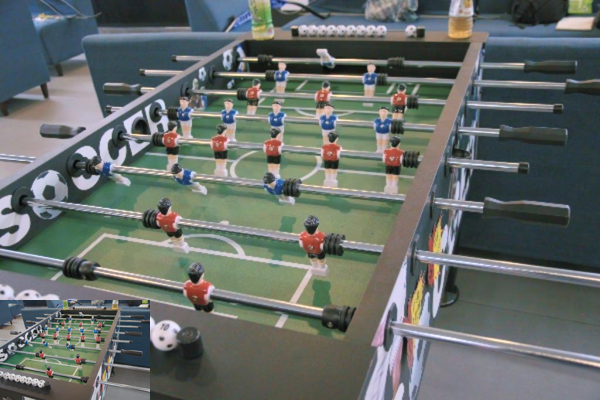

In [17]:
output.paste(style_image, (0, output.height - style_image.height))
display.display(output)